## HW1 - Traffic Sign Image Classification

#### Import required libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from PIL import Image 
from tensorflow.keras import layers, Input
# Splitting data
from sklearn.model_selection import train_test_split
# Metrics 
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import Sequential, load_model

#### Print Tensorflow and Keras version

In [8]:
# print("GPU Available: ", tf.test.is_gpu_available())
print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)

Tensorflow Version:  2.4.0
Keras Version:  2.4.0


In [11]:
# taking Train path and Label path into variables
path = 'GTSRB/Train'
lab = pd.read_csv('GTSRB/labels.csv')

In [12]:
# display labels
lab

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


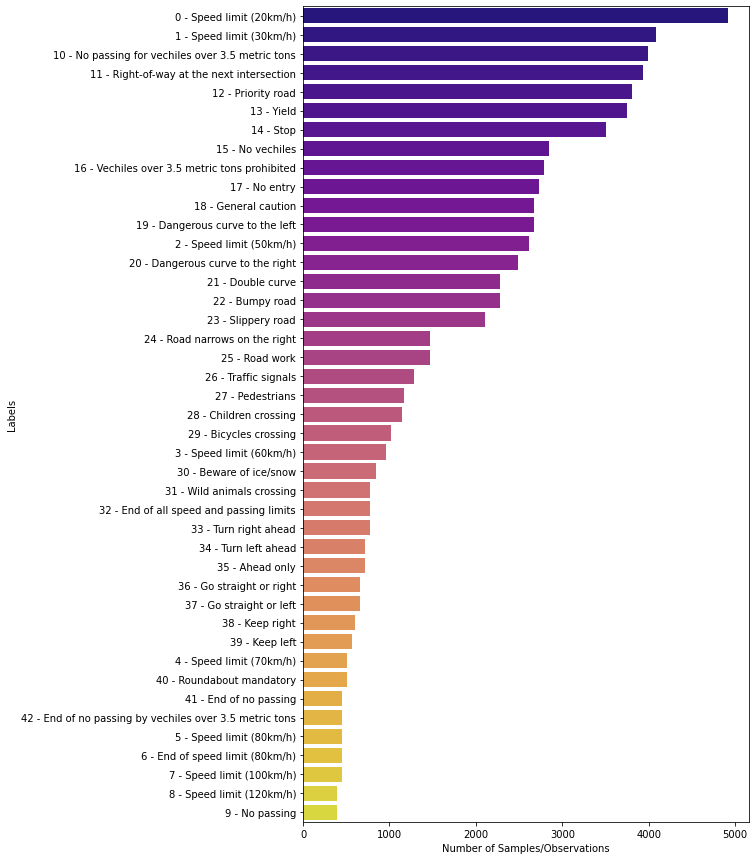

In [13]:
# Count PLot of the samples/observations w.r.t the classes
d = dict()
class_labels = dict()
for dirs in os.listdir(path):
    count = len(os.listdir(path+'/'+dirs))
    d[dirs+' - '+lab[lab.ClassId == int(dirs)].values[0][1]] = count
    class_labels[int(dirs)] = lab[lab.ClassId == int(dirs)].values[0][1]

plt.figure(figsize = (8, 15))
sns.barplot(y = list(d.keys()), x = sorted(list(d.values()), reverse = True), palette = 'plasma')
plt.ylabel('Labels')
plt.xlabel('Number of Samples/Observations');

In [18]:
# Reading train dataset images and labels, converting them into numpy array and appending to a list
train_data = []
train_labels = []
classes = 43
train_dir = 'GTSRB/Train'

for i in range(classes):
    path = os.path.join(train_dir,str(i))
    images = os.listdir(path)

    for img in images:
        image = Image.open(path + '/'+ img)
        image = image.resize((32,32))
        image = np.array(image)
        train_data.append(image)
        train_labels.append(i)

In [19]:
#Converting lists into numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

print(train_data.shape, train_labels.shape)

(73139, 32, 32, 3) (73139,)


In [21]:
#Splitting training and testing dataset
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42, shuffle=True)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(58511, 32, 32, 3) (14628, 32, 32, 3) (58511,) (14628,)


In [22]:
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [23]:
y_train.shape, y_val.shape

((58511, 43), (14628, 43))

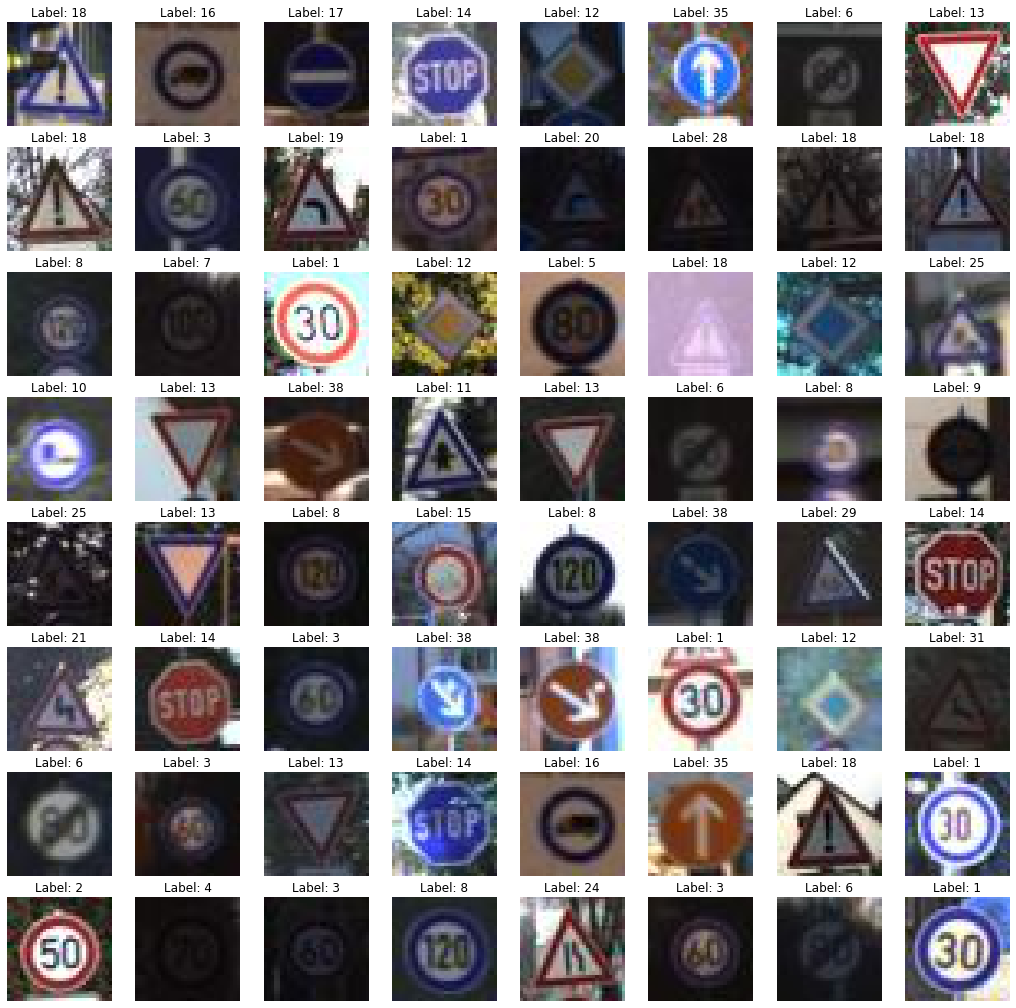

In [24]:
fig, axes = plt.subplots(8,8, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_train.shape[0])
    ax.imshow(X_train[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y_train[r])))

## ResNet-50 Model

In [25]:
# input image dimensions
img_rows, img_cols = 32, 32
# The images are RGB.
img_channels = 3

resnet = ResNet50(weights= None, include_top=False, input_shape= (img_rows,img_cols,img_channels))

In [26]:
# Building the model
classes_count = len(os.listdir(train_dir))
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(classes_count, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

In [27]:
# print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [28]:
# compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
# model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

# early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# csv_logger = CSVLogger('train_log.csv', separator=',')

In [30]:
n_epochs = 15
history =  model.fit(X_train, y_train,  batch_size = 64, epochs = n_epochs, verbose = 1, 
              validation_data = (X_val, y_val)) #, callbacks = [model_check, early, reduce_lr, csv_logger])

Epoch 1/15
915/915 [==============================] - 243s 260ms/step - loss: 4.2211 - accuracy: 0.1462 - val_loss: 16.6411 - val_accuracy: 0.1204
Epoch 2/15
915/915 [==============================] - 236s 258ms/step - loss: 2.2852 - accuracy: 0.5003 - val_loss: 0.7683 - val_accuracy: 0.7706
Epoch 3/15
915/915 [==============================] - 237s 259ms/step - loss: 1.6969 - accuracy: 0.5890 - val_loss: 3.8038 - val_accuracy: 0.1636
Epoch 4/15
915/915 [==============================] - 236s 258ms/step - loss: 2.9568 - accuracy: 0.3256 - val_loss: 6.5715 - val_accuracy: 0.0585
Epoch 5/15
915/915 [==============================] - 237s 259ms/step - loss: 2.4477 - accuracy: 0.3883 - val_loss: 16.5229 - val_accuracy: 0.4255
Epoch 6/15
915/915 [==============================] - 236s 258ms/step - loss: 1.3000 - accuracy: 0.6368 - val_loss: 0.5473 - val_accuracy: 0.8189
Epoch 7/15
915/915 [==============================] - 237s 259ms/step - loss: 0.4564 - accuracy: 0.8591 - val_loss: 0.2782

In [31]:
# Saving the model
model.save('resnet50model.h5')

In [32]:
# Evaluating loss and accuracy of the model
loss, acc = model.evaluate(X_val, y_val)
print('Accuracy: ', acc, '\nLoss    : ', loss)

458/458 [==============================] - 15s 32ms/step - loss: 0.0835 - accuracy: 0.9740
Accuracy:  0.9739540815353394 
Loss    :  0.08353088051080704


#### Test ResNet-50 model using Test Data set

In [34]:
# reading the csv and separating the class id and path
y_test = pd.read_csv('GTSRB/Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

In [36]:
# Reading the test images, converting them into numpy array and appending to a list 
test_images=[]
folder="GTSRB/"
for i in imgs:
    image=Image.open(folder+str(i))
    image=image.resize((32,32))
    test_images.append(np.array(image))

In [37]:
# Using ResNet-50 model to predict on test images
X_test=np.array(test_images)
pred = np.argmax(model.predict(X_test), axis = 1)

In [38]:
pred

array([16,  1, 38, ...,  3,  8, 10])

In [39]:
# Calculating the accuracy score on test data set
from sklearn.metrics import accuracy_score
accuracy_score(labels, pred)

0.9062549485352336

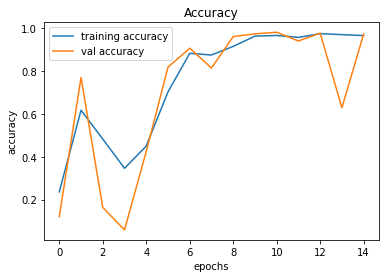

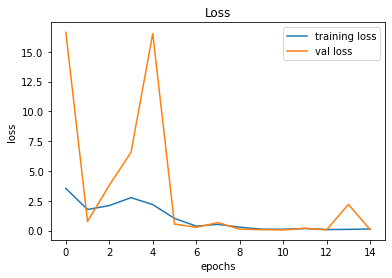

In [40]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

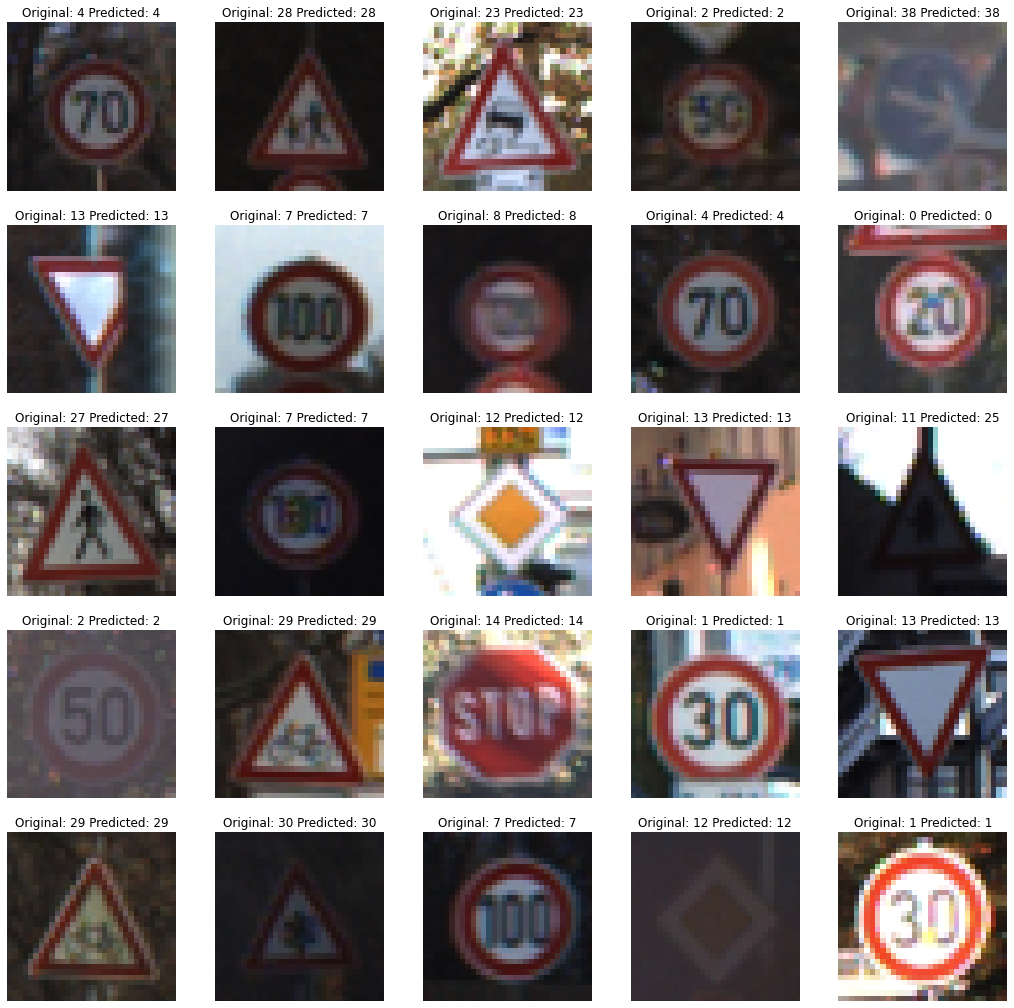

In [44]:
# Plotting the images to show Original and Predicted labels
fig, axes = plt.subplots(5,5, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format((labels[r]), np.argmax(model.predict(X_test[r].reshape(1, 32, 32, 3)))))

### CNN Model

In [14]:
# Reading train dataset images and labels, converting them into numpy array and appending to a list
trainCNN_data = []
labels = []
classes = 43
train_dir = 'GTSRB/Train'

#Retrieving the images and their labels 
for i in range(classes):
    path = os.path.join(train_dir,str(i))
    images = os.listdir(path)

    for img in images:
        image = Image.open(path + '/'+ img)
        image = image.resize((32,32))
        image = np.array(image)
        trainCNN_data.append(image)
        labels.append(i)

In [15]:
#Converting lists into numpy arrays
trainCNN_data = np.array(trainCNN_data)
labels = np.array(labels)

print(trainCNN_data.shape, labels.shape)

(73139, 32, 32, 3) (73139,)


In [16]:
#Splitting training and testing dataset
Xcnn_train, Xcnn_val, ycnn_train, ycnn_val = train_test_split(trainCNN_data, labels, test_size=0.2, random_state=42, shuffle = True)

print(Xcnn_train.shape, Xcnn_val.shape, ycnn_train.shape, ycnn_val.shape)

(58511, 32, 32, 3) (14628, 32, 32, 3) (58511,) (14628,)


In [19]:
#Converting the labels into one hot encoding
ycnn_train = to_categorical(ycnn_train, 43)
ycnn_val = to_categorical(ycnn_val, 43)

In [20]:
ycnn_train.shape, ycnn_val.shape

((58511, 43), (14628, 43))

In [21]:
#Building the model
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=Xcnn_train.shape[1:]))
cnn_model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(rate=0.25))
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
# model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(rate=0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(43, activation='softmax'))

In [22]:
#Compilation of the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0

In [25]:
n_epochs = 15
history = cnn_model.fit(Xcnn_train, ycnn_train, batch_size=64, epochs=n_epochs, verbose = 1, validation_data=(Xcnn_val, ycnn_val))

Epoch 1/15
915/915 [==============================] - 22s 23ms/step - loss: 3.6579 - accuracy: 0.3480 - val_loss: 0.2688 - val_accuracy: 0.9411
Epoch 2/15
915/915 [==============================] - 21s 22ms/step - loss: 0.5615 - accuracy: 0.8382 - val_loss: 0.1238 - val_accuracy: 0.9742
Epoch 3/15
915/915 [==============================] - 20s 22ms/step - loss: 0.3687 - accuracy: 0.8926 - val_loss: 0.0923 - val_accuracy: 0.9793
Epoch 4/15
915/915 [==============================] - 20s 22ms/step - loss: 0.2756 - accuracy: 0.9198 - val_loss: 0.0694 - val_accuracy: 0.9831
Epoch 5/15
915/915 [==============================] - 20s 22ms/step - loss: 0.2514 - accuracy: 0.9294 - val_loss: 0.0595 - val_accuracy: 0.9840
Epoch 6/15
915/915 [==============================] - 22s 24ms/step - loss: 0.2170 - accuracy: 0.9396 - val_loss: 0.0431 - val_accuracy: 0.9871
Epoch 7/15
915/915 [==============================] - 21s 23ms/step - loss: 0.1770 - accuracy: 0.9499 - val_loss: 0.0493 - val_accuracy:

In [28]:
cnn_model.save("cnn_model.h5")

In [ ]:
# Evaluating loss and accuracy of the model
# reading the csv and separating the class id and path
# Reading the test images, converting them into numpy array and appending to a list 
# Using ResNet-50 model to predict on test images
# Calculating the accuracy score on test data set

In [27]:
loss_cnn, acc_cnn = cnn_model.evaluate(Xcnn_val, ycnn_val)
print('Accuracy: ', acc_cnn, '\nLoss    : ', loss_cnn)

458/458 [==============================] - 1s 3ms/step - loss: 0.0247 - accuracy: 0.9934
Accuracy:  0.9934372305870056 
Loss    :  0.024711359292268753


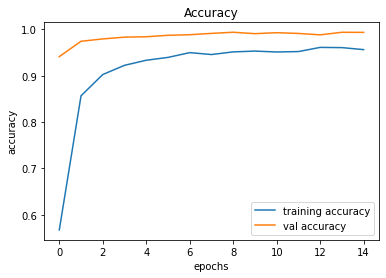

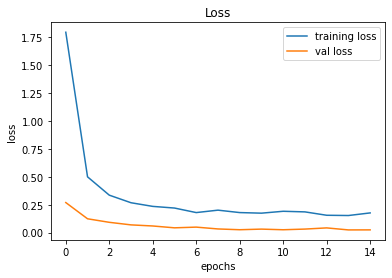

In [29]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [30]:
ycnn_test = pd.read_csv('GTSRB/Test.csv')

labels_cnn = ycnn_test["ClassId"].values
imgs_cnn = ycnn_test["Path"].values

In [31]:
test_images_cnn=[]
folder="GTSRB/"
for i in imgs_cnn:
    image=Image.open(folder+str(i))
    image=image.resize((32,32))
    test_images_cnn.append(np.array(image))

In [33]:
X_test_cnn=np.array(test_images_cnn)
pred_cnn = np.argmax(cnn_model.predict(X_test_cnn), axis = 1)

In [34]:
pred_cnn

array([16,  1, 38, ...,  6,  7, 10])

In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(labels_cnn, pred_cnn)

0.9611243072050673

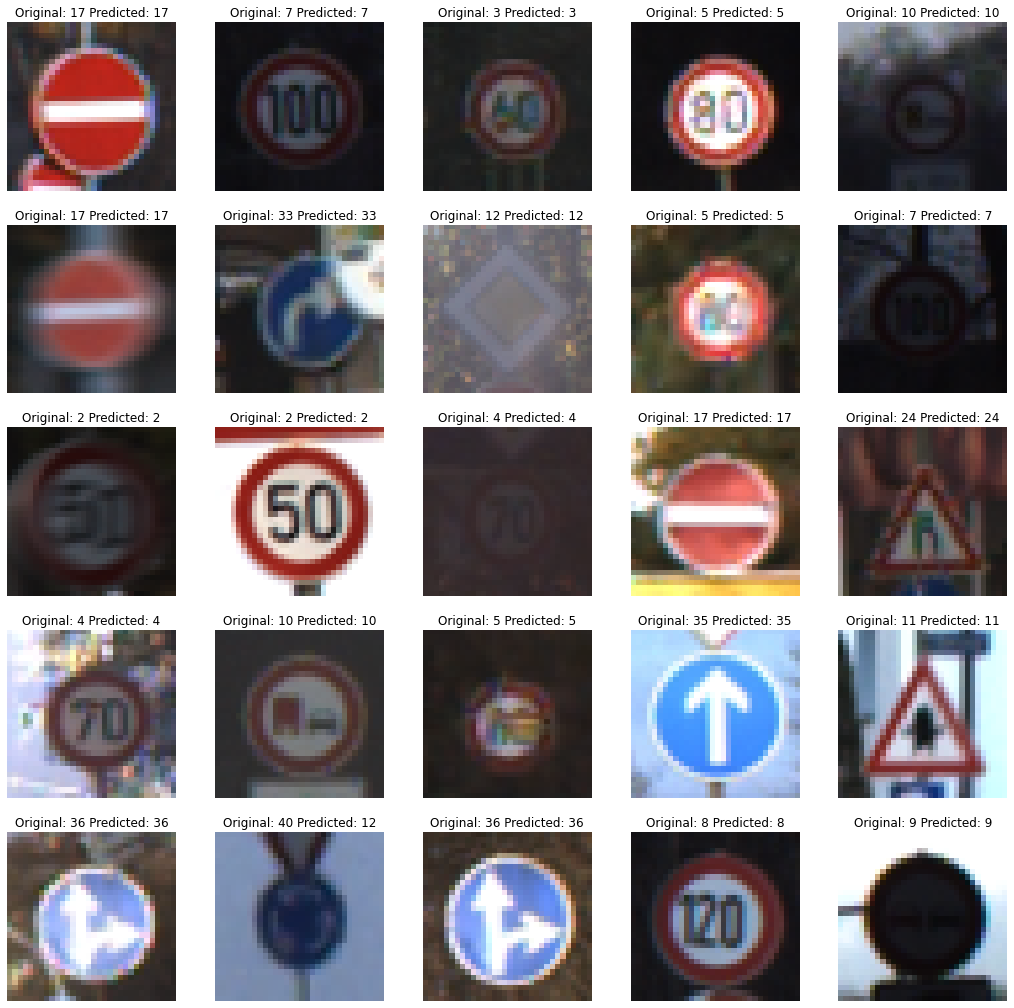

In [38]:
fig, axes = plt.subplots(5,5, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test_cnn.shape[0])
    ax.imshow(X_test_cnn[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format((labels_cnn[r]), np.argmax(cnn_model.predict(X_test_cnn[r].reshape(1, 32, 32, 3)))))

#### References:
- https://www.tensorflow.org/api_docs/python/tf
- https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33